In [1]:
%matplotlib inline
import caffe
import numpy as np
import matplotlib.pyplot as plt

# set display defaults
plt.rcParams['figure.figsize'] = (6, 6)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels

In [2]:
caffe.set_mode_gpu()

In [3]:
model_def = "/home/ubuntu/nexar/caffe/squeeze_net/deploy.prototxt"
model_weights = "/home/ubuntu/nexar/caffe/squeeze_net_trainval_manual/snapshots_p2/train_squeezenet_trainval_manual_p2__iter_3817.caffemodel"

In [4]:
def class_idx_to_name(idx):
    return ['none', 'red', 'green'][idx]

In [5]:
from caffe.classifier import Classifier

In [6]:
c = Classifier(
           model_def, 
           model_weights, 
           mean=np.array([104, 117, 123]),
           raw_scale=255,
           channel_swap=(2,1,0),
           image_dims=(256, 256)
)

In [7]:
# set batch size
BATCH_SIZE = 64
c.blobs['data'].reshape(BATCH_SIZE, 3, c.blobs['data'].shape[2], c.blobs['data'].shape[3])
c.blobs['prob'].reshape(BATCH_SIZE, 3)
c.reshape()

b93dacc37857cbf1bc1462eeda249164.jpg
predicted class is: red


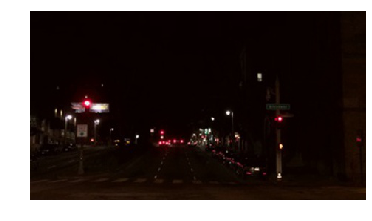

In [21]:
import os, random

images_path = '/mnt/nexar_challenge1_test/'

f = random.choice(os.listdir(images_path))
print f
image = caffe.io.load_image(images_path + f)
cls = c.predict([image]).argmax()
plt.imshow(image)
plt.axis('off')
print 'predicted class is:', class_idx_to_name(cls)

In [22]:
images_paths = os.listdir(images_path)
print "%d images in test-set" % len(images_paths)

478400 images in test-set


In [23]:
print "Number of batches: %s" % (len(images_paths) / float(BATCH_SIZE),)

Number of batches: 7475.0


In [24]:
import pandas as pd
df = pd.DataFrame(index=images_paths, columns=['class', 'p0', 'p1', 'p2'])
df['class'] = -1 * np.ones(len(df), dtype='int32')
df['p0'] = np.nan * np.ones(len(df), dtype='float64')
df['p1'] = np.nan * np.ones(len(df), dtype='float64')
df['p2'] = np.nan * np.ones(len(df), dtype='float64')
print df.dtypes
df.to_csv("/home/ubuntu/nexar/label_test_set/s3/squeeze_net_trainval_manual__os.csv", index_label='fname')

class      int32
p0       float64
p1       float64
p2       float64
dtype: object


In [25]:
def read_imgs(images_paths):
    print "Reading images"
    imgs = []
    for i, f in enumerate(images_paths):
        print "\rAt: %s" % i,
        img = caffe.io.load_image(images_path + f)
        imgs.append(img)
    print "Read %d images" % len(imgs)
    return imgs

In [26]:
num_classes = 3
def predict(c, imgs, oversample):
    probs = np.zeros((0, num_classes))
    for i in xrange(0, len(imgs), BATCH_SIZE):
        print "\rAt:", i,
        input_batch = imgs[i : i+BATCH_SIZE]
        output = c.predict(input_batch, oversample=oversample).reshape((len(input_batch), num_classes))
        probs = np.vstack((probs, output))
    return probs

In [27]:
from scipy import ndimage

def get_rots(imgs):
    rot1 = [np.rot90(i, 1) for i in imgs]
    rot2 = [np.rot90(i, 2) for i in imgs]
    rot3 = [np.rot90(i, 3) for i in imgs]
    rot4 = [np.rot90(i, 4) for i in imgs]
    return [rot1, rot2, rot3, rot4]

def get_probs_with_rots(imgs, c, oversample=False):
    rots = get_rots(imgs)
    probs = []
    for i, rot in enumerate(rots):
        print "rot %s" % i
        probs.append(predict(c, rot, oversample=oversample))

    rots_avg = np.mean(probs, axis=0)
    return rots_avg

In [28]:
UBER_BATCH = 25

In [ ]:
for i in xrange(0, len(images_paths), BATCH_SIZE * UBER_BATCH):
    print "Batch: %d" % i
    img_names = images_paths[i : i + BATCH_SIZE * UBER_BATCH]
    imgs = read_imgs(images_paths[i : i + BATCH_SIZE * UBER_BATCH])
    probs = predict(c, imgs, oversample=True)
    
    for j in xrange(3):
        df.loc[img_names, 'p%d' % j] = probs[:, j]
    df.loc[img_names, 'class'] = probs.argmax(axis=1)
    
    df.to_csv("/home/ubuntu/nexar/label_test_set/s3/squeeze_net_trainval_manual__os.csv", index_label='fname', float_format='%.15f')

Batch: 0
Reading images
At: 1517 